# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  


In [ ]:
import cv2, os

from moviepy.editor import *
expert = cv2.VideoCapture('expert.mp4')
fps_expert = expert.get(cv2.CAP_PROP_FPS)
print(fps_expert)

user = cv2.VideoCapture('user.mp4')
fps_user = user.get(cv2.CAP_PROP_FPS)
print(fps_user)

if fps_expert >= fps_user:
  os.system("ffmpeg -y -i user.mp4 -vf 'setpts=1.25*PTS' -r fps_expert user.mp4")
  user = cv2.VideoCapture('user.mp4')
  fps_user = user.get(cv2.CAP_PROP_FPS)
  print(fps_user)
else:
  os.system("ffmpeg -y -i expert.mp4 -vf 'setpts=1.25*PTS' -r fps_user expert.mp4")
  expert = cv2.VideoCapture('expert.mp4')
  fps_expert = expert.get(cv2.CAP_PROP_FPS)
  print(fps_expert)


30.057
30.132
30.057


In [ ]:
!rm -rf openpose/output1
!rm -rf openpose/output2
!cd openpose && ./build/examples/openpose/openpose.bin --video ../expert.mp4 --write_json ./output1/ --display 0  --render_pose 0
!cd openpose && ./build/examples/openpose/openpose.bin --video ../user.mp4 --write_json ./output2/ --display 0  --render_pose 0


rm: cannot remove 'openpose1.avi': No such file or directory
rm: cannot remove 'openpose2.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 6.487869 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 6.370114 seconds.


## Detect poses on a test video

We are going to detect poses on the following youtube video:

In [ ]:
# import cv2, os

# from moviepy.editor import *
# user = cv2.VideoCapture('user.mp4')
# fps_user = user.get(cv2.CAP_PROP_FPS)
# os.system("ffmpeg -i user.mp4 -r fps_user user%09d.jpg -hide_banner")

In [ ]:
!rm -rf images
!mkdir images
!ffmpeg -i user.mp4 images/user%09d.jpg -hide_banner 

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'user.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42isom
  Duration: 00:00:05.89, start: 0.000000, bitrate: 2163 kb/s
    Stream #0:0(und): Video: h264 (Baseline) (avc1 / 0x31637661), yuv420p(tv, unknown/bt470bg/unknown), 352x640, 2049 kb/s, 30.13 fps, 30.13 tbr, 30132 tbn, 60264 tbc (default)
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 123 kb/s (default)
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mjpeg (native))
Press [q] to stop, [?] for help
[swscaler @ 0x55799252c000] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to 'images/user%09d.jpg':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42isom
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 352x640, q=2-31, 200 kb/s, 30.13 fps, 30.13 tbn, 30.13 tbc (default)
    Metadata:
    

In [ ]:
# !cd openpose && cd output1 && ls

In [ ]:
def compare(frame1,frame2):
  angle_tupple =  makeListOfAngles(frame1, frame2)
  angle1 = angle_tupple[0]
  angle2 = angle_tupple[1]
  k=0
  length=0
  diffsum=0
  while(k<len(angle1) or k<len(angle2)):
    if(angle1[k][1] == False or angle2[k][1] == False):
      k += 1
    else:
      difference=(angle1[k][0]-angle2[k][0]);
      if difference<0:
        diffsum += abs(difference)
      length += 1
      k += 1

  return diffsum/length

def makeSignArray(frame1,frame5):
  angle_tupple =  makeListOfAngles(frame1, frame5)
  angle1 = angle_tupple[0]
  angle2 = angle_tupple[1]
  k=0
  arr={}
  diffsum=0
  while(k<len(angle1) or k<len(angle2)):
    if(angle1[k][1] == False or angle2[k][1] == False):
      k += 1
    else:
      difference=(angle1[k][0]-angle2[k][0]);
      if difference<0:
        arr[k]="-"
      else:
        arr[k]="-"
      k += 1
  return arr

def compareArr(expertArr,noviceArr):
  count=0
  for i in range(0, min(len(expertArr), len(noviceArr))):
    if(expertArr.get(i) and noviceArr.get(i) and expertArr[i]==noviceArr[i]):
      count+=1
  if count > 4:
    return True
  return False

def findFirstFrame(expert,novice):
  i=0
  temp=0
  minimum = 10000000
  Frame=0
  # expertArr=makeSignArray(expert[0],expert[4])
  for j in range(0,100):
    diff=0
    for i in range(0,20):
      diff += compare(novice[j], expert[i])
      j+=1
    j-=20
    # noviceArr=makeSignArray(novice[j],novice[j+5])
   
    # print(str(j) + '-' + str(diff))
    if(diff/20 < minimum ): #and compareArr(expertArr,noviceArr)):
      
      minimum = diff/20
      Frame = j

  return Frame

29


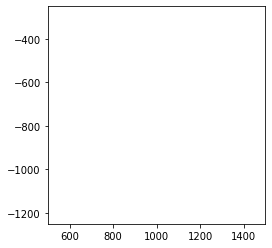

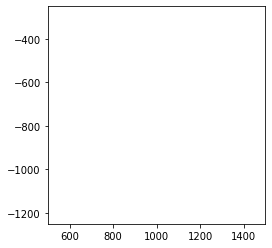

In [ ]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def findKeyPoints(path):
  path_to_json = path

  json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
  json_files.sort()

  points=[]
  for index, js in enumerate(json_files):
      with open(os.path.join(path_to_json, js)) as json_file:
          json_text = json.load(json_file)
          points.append(json_text["people"][0]["pose_keypoints_2d"])
  k=0
  newPoints=[]
  for x in points:
    new=[]
    for i in range(0,len(x),3):
      new.append((x[i],x[i+1],x[i+2]))
    newPoints.append(new)     
#   print(newPoints)

  X =[]
  Y = []
  C=[]
  for i in newPoints:
    x=[]
    y=[]
    c=[]
    for j in i:
      x.append(j[0])
      y.append(j[1])
      c.append(j[2])
    X.append(x)
    Y.append(y)
    C.append(c)
  return (newPoints, X, Y, C)

  
def plotSkeleton(X, Y, C, frame):
  plt.axis([0, 2000, 0, 2000])
  i = [17,15,0,16,0,4,3,2,1,5,6,23,22,11,11,10,9,8,12,13,21,14,19,1]
  j = [15,0,16,18,1,3,2,1,5,6,7,22,11,24,10,9,8,12,13,14,14,19,20,8]
  for z in range(0,len(i)):
    if(C[frame][i[z]]==0 or C[frame][j[z]]==0) :
      continue
    p=[]
    p.append(X[frame][i[z]])
    p.append(X[frame][j[z]])
    q=[]
    q.append(-1*Y[frame][i[z]])
    q.append(-1*Y[frame][j[z]])
    plt.plot(p,q)
  plt.xlim(500,1500)
  plt.ylim(-1250,-250)
  plt.gca().set_aspect('equal')
  plt.show()

  
def plotPointsOnImage(X, Y, C):
  
  string9="000000000"
  for frame in range(0,len(X)):
    temp=string9[:len(string9)-len(str(frame))]
    image='images/user'+temp+str(frame)+".jpg"

    img = cv2.imread(image,cv2.IMREAD_COLOR)

    i = [17,15,0,16,0,4,3,2,1,5,6,23,22,11,11,10,9,8,12,13,21,14,19,1]
    j = [15,0,16,18,1,3,2,1,5,6,7,22,11,24,10,9,8,12,13,14,14,19,20,8]

    
    
    for z in range(0,len(i)):
      if(C[frame][i[z]]==0 or C[frame][j[z]]==0) :
        continue
      
      cv2.line(img,(int(X[frame][i[z]]),int(Y[frame][i[z]])),(int(X[frame][j[z]]),int(Y[frame][j[z]])),(0,255,0),7)
      status = cv2.imwrite(image,img)


  for no in range(0,len(X)):
    temp=string9[:len(string9)-len(str(no))]
    image='images/user'+temp+str(no)+".jpg"

    img = cv2.imread(image,cv2.IMREAD_COLOR)
    for i in range(0,len(X[no])):
      cv2.circle(img,(int(X[no][i]),int(Y[no][i])), 5, (0,0,255), -1)

    status = cv2.imwrite(image,img)



def func(tuple2, tuple1, tuple3):
#    pair <float, bool> p;
  consider=True;
  if(tuple1[2] == 0 or tuple2[2] == 0 or tuple3[2] == 0):
    consider=False
    return (0, consider)
  m1 = math.atan2((tuple2[1]-tuple1[1]),(tuple2[0]-tuple1[0]))
  m2 = math.atan2((tuple3[1]-tuple1[1]),(tuple3[0]-tuple1[0]))
#   tantheta = abs((m2-m1)/(1+m1*m2))
  return (abs(m2-m1), consider)

  
def makeListOfAngles(tuple1,tuple2):
    angle1 = []
  
    angle1.append(func(tuple1[0],tuple1[15],tuple1[17])) #nose reye rear
    angle1.append(func(tuple1[0],tuple1[16],tuple1[18])) #nose leye lear
    angle1.append(func(tuple1[15],tuple1[0],tuple1[16])) #reye nose leye
    angle1.append(func(tuple1[15],tuple1[0],tuple1[1])) #reye nose chest
    angle1.append(func(tuple1[16],tuple1[0],tuple1[1])) #leye nose chest
    angle1.append(func(tuple1[0],tuple1[1],tuple1[2])) #nose chest rshoulder
    angle1.append(func(tuple1[0],tuple1[1],tuple1[5])) #nose chest lshoulder
    angle1.append(func(tuple1[2],tuple1[1],tuple1[8])) #rshoulder chest abdomen
    angle1.append(func(tuple1[5],tuple1[1],tuple1[8])) #lshoulder chest abdomen
    angle1.append(func(tuple1[1],tuple1[2],tuple1[3])) #chest rshoulder relbow
    angle1.append(func(tuple1[1],tuple1[5],tuple1[6]))#chest lshoulder lelbow
    angle1.append(func(tuple1[2],tuple1[3],tuple1[4]))#rshoulder relbow rarm
    angle1.append(func(tuple1[5],tuple1[6],tuple1[7]))#lshoulder lelbow larm
    angle1.append(func(tuple1[1],tuple1[8],tuple1[9]))#chest abdomen rhip
    angle1.append(func(tuple1[1],tuple1[8],tuple1[12]))#chest abdomen lhip
    angle1.append(func(tuple1[8],tuple1[9],tuple1[10]))#abdomen rhip rknee
    angle1.append(func(tuple1[8],tuple1[12],tuple1[13]))#abdomen lhip lknee
    angle1.append(func(tuple1[9],tuple1[8],tuple1[12]))#rhip abdomen lhip
    angle1.append(func(tuple1[9],tuple1[10],tuple1[11]))#rhip rknee rankle
    angle1.append(func(tuple1[12],tuple1[13],tuple1[14]))#lhip lknee lankle
    angle1.append(func(tuple1[10],tuple1[11],tuple1[24]))#rknee rankle rheel
    angle1.append(func(tuple1[13],tuple1[14],tuple1[21]))#lknee lankle lheel
    angle1.append(func(tuple1[11],tuple1[22],tuple1[23]))#rankle rfrontfoot rtoe
    angle1.append(func(tuple1[14],tuple1[19],tuple1[20]))#lankle lfrontfoot ltoe
    angle1.append(func(tuple1[24],tuple1[11],tuple1[22]))#rheel rankle rfrontfoot
    angle1.append(func(tuple1[21],tuple1[14],tuple1[19]))#lheel lankle lfrontfoot
    angle1.append(func(tuple1[2],tuple1[1],tuple1[5]))#rshoulder chest lshoulder
   
    angle2 = []
   
    angle2.append(func(tuple2[0],tuple2[15],tuple2[17])) #nose reye rear
    angle2.append(func(tuple2[0],tuple2[16],tuple2[18])) #nose leye lear
    angle2.append(func(tuple2[15],tuple2[0],tuple2[16])) #reye nose leye
    angle2.append(func(tuple2[15],tuple2[0],tuple2[1])) #reye nose chest
    angle2.append(func(tuple2[16],tuple2[0],tuple2[1])) #leye nose chest
    angle2.append(func(tuple2[0],tuple2[1],tuple2[2])) #nose chest rshoulder
    angle2.append(func(tuple2[0],tuple2[1],tuple2[5])) #nose chest lshoulder
    angle2.append(func(tuple2[2],tuple2[1],tuple2[8])) #rshoulder chest abdomen
    angle2.append(func(tuple2[5],tuple2[1],tuple2[8])) #lshoulder chest abdomen
    angle2.append(func(tuple2[1],tuple2[2],tuple2[3])) #chest rshoulder relbow
    angle2.append(func(tuple2[1],tuple2[5],tuple2[6]))#chest lshoulder lelbow
    angle2.append(func(tuple2[2],tuple2[3],tuple2[4]))#rshoulder relbow rarm
    angle2.append(func(tuple2[5],tuple2[6],tuple2[7]))#lshoulder lelbow larm
    angle2.append(func(tuple2[1],tuple2[8],tuple2[9]))#chest abdomen rhip
    angle2.append(func(tuple2[1],tuple2[8],tuple2[12]))#chest abdomen lhip
    angle2.append(func(tuple2[8],tuple2[9],tuple2[10]))#abdomen rhip rknee
    angle2.append(func(tuple2[8],tuple2[12],tuple2[13]))#abdomen lhip lknee
    angle2.append(func(tuple2[9],tuple2[8],tuple2[12]))#rhip abdomen lhip
    angle2.append(func(tuple2[9],tuple2[10],tuple2[11]))#rhip rknee rankle
    angle2.append(func(tuple2[12],tuple2[13],tuple2[14]))#lhip lknee lankle
    angle2.append(func(tuple2[10],tuple2[11],tuple2[24]))#rknee rankle rheel
    angle2.append(func(tuple2[13],tuple2[14],tuple2[21]))#lknee lankle lheel[(0, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0.2415202306868005, True), (0, False), (0.29741777647249146, True), (0, False), (0.34634776558756464, True), (0, False), (0, False), (0, False), (0, False), (0.24344605245181516, True), (0, False), (0.20710045738501126, True), (0, False), (0.1975046721975131, True), (0, False), (0, False), (0, False), (0, False), (0, False), (0.23129248543623304, True), (0.3145668793628751, True)]
    angle2.append(func(tuple2[11],tuple2[22],tuple2[23]))#rankle rfrontfoot rtoe
    angle2.append(func(tuple2[14],tuple2[19],tuple2[20]))#lankle lfrontfoot ltoe
    angle2.append(func(tuple2[24],tuple2[11],tuple2[22]))#rheel rankle rfrontfoot
    angle2.append(func(tuple2[21],tuple2[14],tuple2[19]))#lheel lankle lfrontfoot
    angle2.append(func(tuple2[2],tuple2[1],tuple2[5]))#rshoulder chest lshoulder
    
    return (angle1,angle2)

def comparison(dict1, dict2):
  result = {}
  for i in range(0, len(dict1)):  #Assumption-> No. of frames are equal
    tuple1 = dict1[i]

  for i in range(0,len(dict2)):
    tuple2 = dict2[i] 
    
#     for j in range(0, len(dict1[i])):
#       tuple1[j]=dict1[i][j]
#     for j in range(0, len(dict2[j])):
#       tuple2[j]=dict2[i][j]

    angle1,angle2 =  makeListOfAngles(tuple1,tuple2)

    
    diff = []
    k=0
    while(k<len(angle1) or k<len(angle2)):
      if(angle1[k][1] == False or angle2[k][1] == False):   #some error
        diff.append((0,False))
        k += 1
      else:
        difference=abs(angle1[k][0]-angle2[k][0]);
        if(difference <= 0.1872665):
          diff.append((0,False))
        else:
          diff.append((difference, True))
        k += 1
    result[i] = diff
  return result
    
def main():
  tup1 = findKeyPoints('openpose/output1')
  tup2 = findKeyPoints('openpose/output2')

  # print(tup1[0])
  item1 = {}
  item2 = {}
  for i in range(0, len(tup1[0])):
    item1[i] = tup1[0][i]

  for i in range(0, len(tup2[0])):
    item2[i] = tup2[0][i]

  # item2[57][6][0] =  400[(0, False), (0, False), (0, False), (0, False), (0, False), (0, False), (0.2415202306868005, True), (0, False), (0.29741777647249146, True), (0, False), (0.34634776558756464, True), (0, False), (0, False), (0, False), (0, False), (0.24344605245181516, True), (0, False), (0.20710045738501126, True), (0, False), (0.1975046721975131, True), (0, False), (0, False), (0, False), (0, False), (0, False), (0.23129248543623304, True), (0.3145668793628751, True)]
  diff = comparison(item1, item2);
 

  frameNo = findFirstFrame(item1,item2)
  print(frameNo)
  # print(diff)
  # print(len(item1))
  # print(len(item2))

  points_to_bodyParts={0:'nose reye rear',1:'nose leye lear',2:'reye nose leye',3:'reye nose chest',4:'leye nose chest',5:'nose chest rshoulder',6:'nose chest lshoulder',7:'rshoulder chest abdomen',8:'lshoulder chest abdomen',9:'chest rshoulder relbow',10:'chest lshoulder lelbow',11:'rshoulder relbow rarm',12:'lshoulder lelbow larm',13:'chest abdomen rhip',14:'chest abdomen lhip',15:'abdomen rhip rknee',16:'abdomen lhip lknee',17:'rhip abdomen lhip',18:'rhip rknee rankle',19:'lhip lknee lankle',20:'rknee rankle rheel',21:'lknee lankle lheel',22:'rankle rfrontfoot rtoe',23:'lankle lfrontfoot ltoe',24:'rheel rankle rfrontfoot',25:'lheel lankle lfrontfoot',26:'rshoulder chest lshoulder'}

  changes = {}
  for i in range(0, len(diff)):
    angleDiffList = []
    for j in range(0, len(diff[i])):
      if(diff[i][j][1] == True ):
        angleDiffList.append(points_to_bodyParts[j])
    changes[i] = angleDiffList
  # print(changes)
  for i in changes:
    # print(changes[i])
    plotSkeleton(tup1[1], tup1[2], tup1[3], i)
    plotSkeleton(tup2[1], tup2[2], tup2[3], i)
    break

  plotPointsOnImage(tup1[1], tup1[2], tup1[3])

if __name__ == "__main__": 
  main()
  

In [ ]:
def clipUserVideo(frameNo,lastframeNo):
  expert = cv2.VideoCapture('expert.mp4')
  fps = expert.get(cv2.CAP_PROP_FPS)
  time1=frameNo/fps
  time2=lastframeNo/fps
  print(time1,time2)
  command = "ffmpeg -i user.mp4 -vf trim=" + str(time1) + ":" + str(time2) + " userMod.mp4"
  os.system(command)

In [ ]:
command = "ffmpeg -i user.mp4 -vf trim=" + str(time1) + ":" + str(time2) + " userMod.mp4"
os.system(command)

0

In [ ]:
command = "cd images && ffmpeg -framerate " + str(fps_expert) + " -f image2 -s 1920x1080 -pix_fmt yuv420p -i user%09d.jpg -vcodec libx264 -crf " + str(fps_expert) + " out.mp4"
os.system(command)


0